## THIS IS THE FOURTH NOTEBOOK FOR THE FINAL PROJECT

In [1]:
from tpqoa import tpqoa
import numpy as np
import pandas as pd
import tables as tb
import tstables as tstb
import pickle
import datetime
import time
import logging
import sys
sys.path.insert(0, '/root/')
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline


class tradingstrategy(tpqoa):
    '''class for trading strategy using lagged returns, rsi and macd
    indicators. Optimised using logistic regression.
    '''
    def __init__(self, conf_file, instrument):
        tpqoa.__init__(self, conf_file)
        self.instrument = instrument
        self.live_data = pd.DataFrame()
        self.position = 0
        self.ticks = 0
        self.units = 100000
        self.rsi_n = 21
        self.mom1 = 2
        self.mom2 = 5
        self.lags = 20
        self.model = linear_model.LogisticRegression()
        logging.basicConfig(filename="tradingstrategy.log",level=logging.DEBUG,
                    format="%(asctime)s %(name)s.%(funcName)s +%(lineno)s: %(levelname)-8s %(message)s", 
                    datefmt ='%d/%m/%y %I:%M:%S %P')
        
    def stream_data(self, stop = None):
        # self.stoptime = datetime.datetime(2018, 5, 25, 4, 0, 0, 0)
        ''' starts a real time Oanda data stream'''
        self.ticks = 0
        response = self.ctx_stream.pricing.stream(self.account_id, snapshot = True,
                                                 instruments = self.instrument)
        for msg_type, msg in response.parts():
            if msg_type == 'pricing.Price':
                self.on_success(msg.time,
                              float(msg.bids[0].price),
                              float(msg.asks[0].price))
                if stop is not None:
                    if self.ticks >= stop:
                        self.close_out(stop)
                        break
                            
    def on_success(self, time, bid, ask):
        '''Method called when new data is received. This updates the on_success
        method originally in the tpqoa class inherited by tradingstrategy class
        which merely printed and timestamped bid and ask prices'''
        self.ticks += 1
        if self.ticks % 1 == 0:
            print('%3d | '% self.ticks, time, bid, ask)
            
        self.live_data = self.live_data.append(pd.DataFrame({'bid':bid, 
                                                             'ask': ask},
                                                            index = [pd.Timestamp(time)]))
        self.dataresam = self.live_data.resample('5s', label = 'right').last().ffill().iloc[:-1]
        self.dataresam['mid'] = self.dataresam.mean(axis=1)
        self.dataresam['returns'] = np.log(self.dataresam['mid'] / self.dataresam['mid'].shift(1))
        if len(self.dataresam) > 22: # self.mom2: ******************************
                                                # *****************************
            self.dataresam['RSI'] = self.relative_strength(self.dataresam['mid'], self.rsi_n)
            self.dataresam['MACD'] = self.macd(self.dataresam['mid'])
            self.dataresam = self.prepare_features(self.dataresam, self.lags)
            self.load_model()
    
    def relative_strength(self, data, rsi_n):
        '''Creates RSI feature -
        initial RSI value created here'''
        abchange = (data - data.shift(1)) # calculate absolute daily change
        rsperiod = abchange[:rsi_n + 1]
        upday = rsperiod[rsperiod >= 0].sum() / rsi_n # in the RSI period what is the up day change
        dnday = -rsperiod[rsperiod < 0].sum() / rsi_n # in the RSI period what is the down day change
        rs = upday / dnday # up day change/down day change ratio
        rsi = np.zeros_like(data)
        rsi[:rsi_n] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
        
        '''calculates subsequent change in RSI values'''
        for i in range(rsi_n, len(data)):
            abchg = abchange[i - 1]
            if abchg > 0:
                upval = abchg
                dnval = 0
            else:
                upval = 0
                dnval = abs(abchg)
            
            # iterate through each daily change proportionally adding it
            # to the respective RSI period change
            upday = (upday * (rsi_n - 1) + upval) / rsi_n
            dnday = (dnday * (rsi_n - 1) + dnval) / rsi_n
            
            rs = upday / dnday # up day change/down day change ratio
            rsi[i] = 100. - (100. / ( 1. + rs)) # formula for RSI Index calculation
        rsi = pd.DataFrame(rsi)
        rsi.index = data.index
        rsi.columns = ['RSI']
        return rsi # Return the RSI Index value calculated
    
    def macd(self, data, slow = 26, fast = 12, signal = 9):
        # calculate respective fast and slow exponential moving averages
        ema_fast = data.ewm(span = fast).mean()
        ema_slow = data.ewm(span = slow).mean()
        # MACD line is slow m.a. minus fast m.a.
        macd_line = ema_slow - ema_fast
        # signal line is 9 day ema of macd line
        sig_line = macd_line.ewm(span = signal).mean()
        # macd histogram is the macd line minus the signal line
        macd_hist = macd_line - sig_line
        macd_hist = pd.DataFrame(macd_hist)
        macd_hist.columns = ['MACD']
        return macd_hist
            
    def prepare_features(self, df, lagz):
        '''creates lagged and momentum features'''
        self.cols = []
        
        #self.features = ['RSI','MACD','Returns']
        # add lagged RSI and MACD data, backtest suggests 1
        # lagged return only
        for feat1 in ['RSI','MACD']:
            lag1 = 1
            col = '%s_lag_%d' % (feat1, lag1)
            df[col] = df[feat1].shift(lag1)
            self.cols.append(col)
            
        # add lagged return data, backtest suggests 20
        # lagged returns        
        for lag in range(1,lagz + 1):
            col = 'Returns_lag_%d' % lag
            df[col] = df['returns'].shift(lag)
            self.cols.append(col)
            
        # add short term momentum signal
        df['MOM1'] = np.where(df['returns'].rolling(self.mom1).mean() > 0, 1, 0)
        df['MOM1'] = df['MOM1'].shift(1)
        self.cols.append('MOM1')
        # add long term momentum signal
        df['MOM2'] = np.where(df['returns'].rolling(self.mom2).mean() > 0, 1, 0)
        df['MOM2'] = df['MOM2'].shift(1)
        self.cols.append('MOM2')
        df.dropna(inplace = True)
        return df
    
    def load_model(self):
        LinMod = pickle.load(open('final_model.sav','rb'))
        pred = LinMod.predict(self.dataresam[self.cols])
        self.dataresam['prediction'] = pred
        self.execute_order()
        
    def execute_order(self):
        # Entering long
        if self.dataresam['prediction'].iloc[-2] > 0 and self.position == 0:
            print('going long')
            self.position = 1
            self.create_order(self.instrument, self.units)
            logging.info('going long | %s | units %4d | ask %0.5f' % 
                         (self.instrument, self.units, self.dataresam.iloc[-1]['ask']))
            
        elif self.dataresam['prediction'].iloc[-2] > 0 and self.position == -1:
            print('covering short and going long')
            self.position = 1
            self.create_order(self.instrument, 2 * self.units)
            logging.info('covering short and going long | %s | units %4d | ask %0.5f' %
                         (self.instrument, self.units, self.dataresam.iloc[-1]['ask']))
            
        # Entering short
        elif self.dataresam['prediction'].iloc[-2] < 0 and self.position == 0:
            print('going short')
            self.position = -1
            self.create_order(self.instrument, units = -self.units)
            logging.info('going short | %s | units %4d | bid %0.5f' % 
                         (self.instrument, self.units, self.dataresam.iloc[-1]['bid']))
            
        elif self.dataresam['prediction'].iloc[-2] < 0 and self.position == 1:
            print('covering long and going short')
            self.position = -1
            self.create_order(self.instrument, units = -2 * self.units)
            logging.info('covering long and going short | %s | units %4d | bid %0.5f' %
                         (self.instrument, self.units, self.dataresam.iloc[-1]['bid']))      
                
    def close_out(self, stop):
        if self.ticks >= stop:
            logging.info('stop reached')
        
            # stop reached close out long position
            if self.position == 1:
                self.create_order(self.instrument, 
                                  units = -self.units)
                logging.info('stop reached - closing long, no open positions| %s | units %4d | bid %0.5f' 
                             % (self.instrument, self.units, self.dataresam.iloc[-1]['bid']))
                print('stop reached - closing long, no open positions') 
                self.position = 0
                
            # stop reached close out short position
            elif self.position == -1:
                self.create_order(self.instrument, units = self.units)
                logging.info('stop reached - closing short, no open position| %s | units %4d | ask %0.5f' 
                             % (self.instrument, self.units, self.dataresam.iloc[-1]['ask']))
                print('stop reached - closing short, no open positions')
                self.position = 0
        
            print(15 * '-')
            # sys.exit('Trading has stopped')

In [2]:
rt = tradingstrategy('/root/pyalgo.cfg','AUD_USD')

In [3]:
rt.stream_data(stop = 25)

  1 |  2018-05-29T01:01:24.353956914Z 0.75464 0.75479
  2 |  2018-05-29T01:01:56.184267477Z 0.75461 0.75475
  3 |  2018-05-29T01:01:58.894070586Z 0.75457 0.75472
  4 |  2018-05-29T01:01:59.483796552Z 0.75454 0.75468
  5 |  2018-05-29T01:02:00.187626887Z 0.7546 0.75475
  6 |  2018-05-29T01:02:00.507640183Z 0.75467 0.7548
  7 |  2018-05-29T01:02:06.763152168Z 0.75463 0.75476
  8 |  2018-05-29T01:02:22.320559141Z 0.75468 0.75483
  9 |  2018-05-29T01:03:11.030571537Z 0.75474 0.75488
 10 |  2018-05-29T01:03:21.570518552Z 0.7547 0.75484
going long


 {'id': '2762', 'time': '2018-05-29T01:03:22.850729953Z', 'userID': 8094291, 'accountID': '101-011-8094291-001', 'batchID': '2761', 'requestID': '60450228942428064', 'type': 'ORDER_FILL', 'orderID': '2761', 'instrument': 'AUD_USD', 'units': '100000.0', 'price': '0.75484', 'fullPrice': {'bids': [{'price': '0.7547', 'liquidity': '10000000'}], 'asks': [{'price': '0.75484', 'liquidity': '10000000'}], 'closeoutBid': '0.75455', 'closeoutAsk': '0.75499'

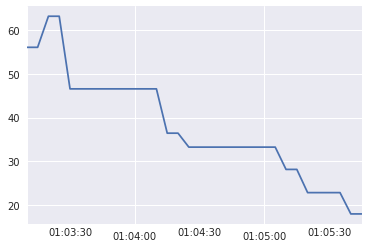

In [4]:
rt.dataresam['RSI'].plot()

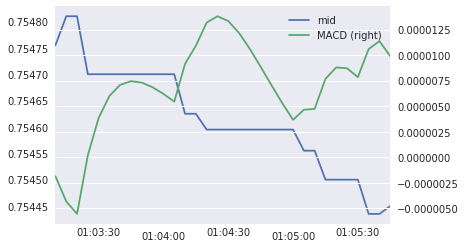

In [5]:
rt.dataresam[['mid','MACD']].plot(secondary_y = 'MACD')

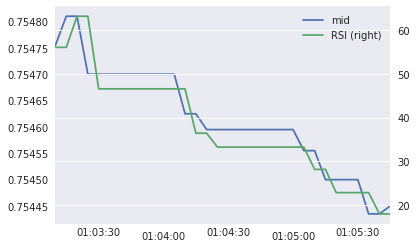

In [6]:
rt.dataresam[['mid','RSI']].plot(secondary_y='RSI')

In [7]:
rt.dataresam.head()

,ask,bid,mid,returns,RSI,MACD,RSI_lag_1,MACD_lag_1,Returns_lag_1,Returns_lag_2,...,Returns_lag_14,Returns_lag_15,Returns_lag_16,Returns_lag_17,Returns_lag_18,Returns_lag_19,Returns_lag_20,MOM1,MOM2,prediction
2018-05-29 01:03:10+00:00,0.75483,0.75468,0.754755,0.000000,56.060606,-1.859477e-06,56.060606,-2.416411e-06,0.000000,0.000000,...,-0.000139,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
2018-05-29 01:03:15+00:00,0.75488,0.75474,0.754810,0.000073,56.060606,-4.329069e-06,56.060606,-1.859477e-06,0.000000,0.000000,...,0.000166,-0.000139,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
2018-05-29 01:03:20+00:00,0.75488,0.75474,0.754810,0.000000,63.167061,-5.548441e-06,56.060606,-4.329069e-06,0.000073,0.000000,...,-0.000053,0.000166,-0.000139,0.000000,0.000000,0.0,0.0,1.0,1.0,-1.0
2018-05-29 01:03:25+00:00,0.75476,0.75464,0.754700,-0.000146,63.167061,1.951979e-07,63.167061,-5.548441e-06,0.000000,0.000073,...,0.000000,-0.000053,0.000166,-0.000139,0.000000,0.0,0.0,1.0,1.0,-1.0
2018-05-29 01:03:30+00:00,0.75476,0.75464,0.754700,0.000000,46.562037,3.850173e-06,63.167061,1.951979e-07,-0.000146,0.000000,...,0.000000,0.000000,-0.000053,0.000166,-0.000139,0.0,0.0,0.0,0.0,1.0


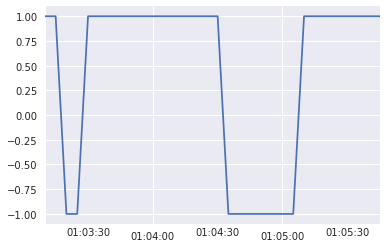

In [8]:
rt.dataresam['prediction'].plot()

In [9]:
rt.dataresam.iloc[-1]['bid']

0.75438

In [10]:
rt.live_data.iloc[-1]['bid']

0.75431